In [1]:
import requests  # Pour obtenir des pages web.
from bs4 import BeautifulSoup  # Pour lire et analyser le contenu HTML des pages web.
import json  # Pour travailler avec des fichiers JSON (enregistrer et lire).
from google.colab import files  # Pour gérer les fichiers dans Google Colab (ici, pour télécharger).

url = 'https://countries-worldwide.com/fr/indice-de-criminalite-par-pays/'
response = requests.get(url)# Télécharge la page web.
response.encoding = 'utf-8' # S'assure que les caractères spéciaux sont bien traités (accents, etc.)

soup = BeautifulSoup(response.content, 'html.parser') # Analyse le HTML de la page téléchargée.
# Extraction du tableau contenant les données de site
table = soup.find('table', {'id': 'tablepress-34'})
header = table.find('thead').find_all('th')
columns = [th.text.strip() for th in header]# Récupère les noms des colonnes

rows = table.find_all('tr')# Trouver toutes les lignes du tableau (sauf l'entête)
data = []
for row in rows:# Parcours des lignes du tableau
    cols = row.find_all('td') # Trouve toutes les lignes du tableau.
    if len(cols) > 0:
        entry = {
            columns[0]: cols[0].text.strip(),
            columns[1]: cols[1].text.strip(),
            columns[2]: cols[2].text.strip(),
            columns[3]: cols[3].text.strip()  # On prend la 4ème colonne
        }
        data.append(entry)
for entry in data:
    print(entry)  # Affiche chaque entrée sous forme de dictionnaire.

output_path = "/content/safety_data.json"# Définir le chemin de sortie pour le fichier JSON
with open(output_path, mode='w', encoding='utf-8') as file:
    json.dump(data, file, ensure_ascii=False, indent=4)
files.download(output_path)# Télécharger le fichier JSON automatiquement


{'Rang': '1', 'Pays': 'Venezuela', 'Indice de criminalité': '81.2', 'Indice de sécurité': '18.8'}
{'Rang': '2', 'Pays': 'Papouasie Nouvelle Guinée', 'Indice de criminalité': '79.7', 'Indice de sécurité': '20.3'}
{'Rang': '3', 'Pays': 'Afghanistan', 'Indice de criminalité': '78.3', 'Indice de sécurité': '21.7'}
{'Rang': '4', 'Pays': 'Haïti', 'Indice de criminalité': '77.9', 'Indice de sécurité': '22.1'}
{'Rang': '5', 'Pays': 'Afrique du Sud', 'Indice de criminalité': '75.4', 'Indice de sécurité': '24.6'}
{'Rang': '6', 'Pays': 'Honduras', 'Indice de criminalité': '73.4', 'Indice de sécurité': '26.6'}
{'Rang': '7', 'Pays': 'Trinité-et-Tobago', 'Indice de criminalité': '70.8', 'Indice de sécurité': '29.2'}
{'Rang': '8', 'Pays': 'Syrie', 'Indice de criminalité': '69.1', 'Indice de sécurité': '30.9'}
{'Rang': '9', 'Pays': 'Yémen', 'Indice de criminalité': '68.6', 'Indice de sécurité': '31.4'}
{'Rang': '10', 'Pays': 'Jamaïque', 'Indice de criminalité': '68.1', 'Indice de sécurité': '31.9'}
{'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# === Importation des bibliothèques nécessaires ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import json

# === Création de la session Spark ===
spark = SparkSession.builder \
    .appName("Fusion des données touristiques et de sécurité") \
    .master("local[*]") \
    .getOrCreate()

# === 1. Chargement des données de sécurité (CSV) ===
safety_data = spark.read \
    .option("multiline", "true") \
    .json("/content/safety_data.json")

# Vérifiez la structure du fichier (pour identifier les noms de colonnes exacts)
safety_data.printSchema()

# === 2. Chargement des données des lieux touristiques (JSON) ===
# Lecture du fichier JSON contenant les lieux touristiques
tourist_places_data = spark.read \
    .option("multiline", "true") \
    .json("/content/Lieuxtouristiques.json")

# Vérifiez la structure du fichier (pour identifier les noms de colonnes exacts)
tourist_places_data.printSchema()

# === 3. Fusion des ensembles de données (sur la colonne 'country' et 'pays') ===
merged_data = safety_data.join(
    tourist_places_data,
    safety_data["pays"] == tourist_places_data["pays"],
    "left"
)

# === 4. Sélection des colonnes nécessaires et renommage ===
result = merged_data.select(
    safety_data["Pays"].alias("pays"),  # Nom du pays
    tourist_places_data["nom"],  # Nom du lieu touristique
    tourist_places_data["description"],  # Description du lieu touristique
    col("Indice de sécurité").alias("safety"),  # Indice de sécurité (nom corrigé)
    col("Indice de criminalité").alias("crime"),
    tourist_places_data["image"].alias("urlimage")  # URL de l'image
)



# === 5. Trier les résultats par l'indice de sécurité (du plus sûr au moins sûr) ===
sorted_result = result.orderBy(col("safety").desc())

# === 6. Collecte des résultats sous forme de liste de dictionnaires ===
result_list = sorted_result.collect()
result_dict_list = [row.asDict() for row in result_list]

# === 7. Sauvegarde du résultat au format JSON ===
output_path = "/content/structured_final.json"
with open(output_path, mode='w', encoding='utf-8') as file:
    json.dump(result_dict_list, file, ensure_ascii=False, indent=4)

# === 8. Téléchargement du fichier (uniquement pour Google Colab) ===
try:
    from google.colab import files
    files.download(output_path)
except ImportError:
    print(f"Fichier enregistré à {output_path}")


root
 |-- Indice de criminalité: string (nullable = true)
 |-- Indice de sécurité: string (nullable = true)
 |-- Pays: string (nullable = true)
 |-- Rang: string (nullable = true)

root
 |-- description: string (nullable = true)
 |-- image: string (nullable = true)
 |-- nom: string (nullable = true)
 |-- pays: string (nullable = true)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

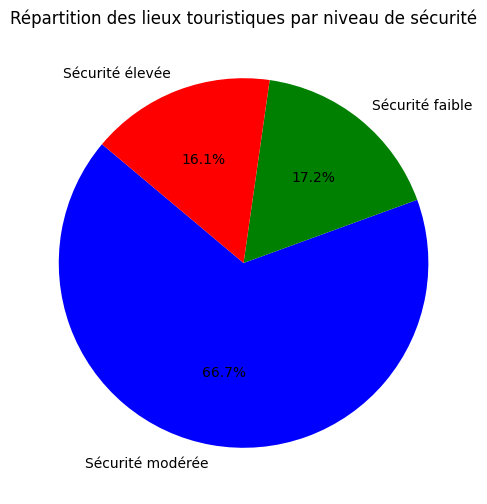

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
!pip install pyspark pandas matplotlib
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
#Analyse de la Sécurité des Lieux Touristiques: Répartition par Catégorie de Sécurité
# Initialisation de la session Spark
spark = SparkSession.builder.appName("TourismeSafety").getOrCreate()

# Charger les données JSON
lieuxtouristique_path = "/content/structured_final.json"
df = spark.read.option("multiline", "true").json(lieuxtouristique_path)

# Convertir les données PySpark en DataFrame Pandas
pandas_df = df.select("pays", "nom", "description", "safety").toPandas()

# Convertir la colonne 'safety' en valeurs numériques, les erreurs sont converties en NaN
pandas_df["safety"] = pd.to_numeric(pandas_df["safety"], errors="coerce")

# Supprimer les lignes avec des valeurs nulles dans la colonne 'safety'
pandas_df.dropna(subset=["safety"], inplace=True)

# Ajouter une colonne catégorisée pour la sécurité
pandas_df["safety_category"] = pd.cut(
    pandas_df["safety"],
    bins=[0, 40, 70, 100],
    labels=["Sécurité faible", "Sécurité modérée", "Sécurité élevée"]
)

# Compter le nombre d'occurrences de chaque catégorie de sécurité
category_counts = pandas_df["safety_category"].value_counts()

# Tracer un diagramme circulaire des catégories de sécurité
plt.figure(figsize=(6, 6))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=["blue", "green", "red"]
)
plt.title("Répartition des lieux touristiques par niveau de sécurité")
plt.savefig("/content/safety_category_pie_chart.png")
plt.show()

# Télécharger le graphique
files.download("/content/safety_category_pie_chart.png")


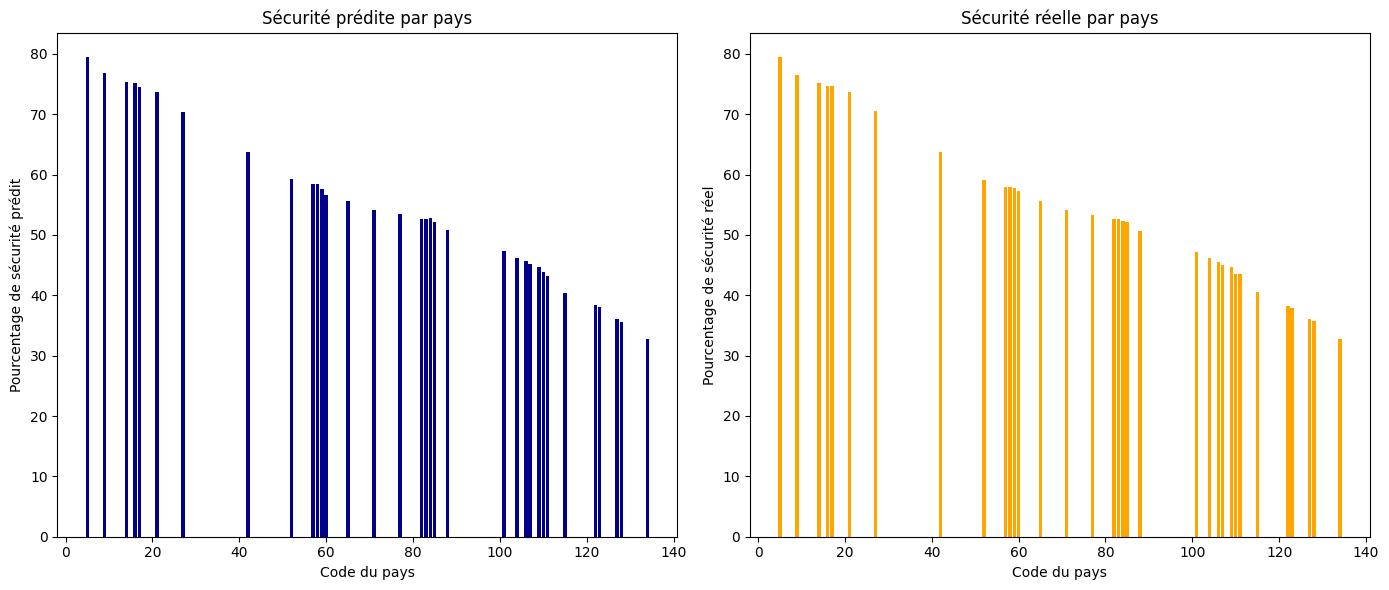

In [6]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Initialiser la session Spark
spark = SparkSession.builder.appName("DataAnalysis").getOrCreate()

# Charger les données depuis le fichier JSON
input_path = "/content/structured_final.json"
df1 = spark.read.option("multiline", "true").json(input_path)

# Convertir les données PySpark en DataFrame Pandas avec les colonnes nécessaires
df_pandas = df1.select("pays", "safety", "nom", "crime").toPandas()

# S'assurer que les colonnes 'safety' et 'crime' sont bien des nombres
df_pandas['safety'] = pd.to_numeric(df_pandas['safety'], errors='coerce')
df_pandas['crime'] = pd.to_numeric(df_pandas['crime'], errors='coerce')

# Convertir les données catégorielles ('pays') en valeurs numériques
df_pandas['pays_code'], unique_pays = pd.factorize(df_pandas['pays'])

# Convertir les lieux touristiques ('leux_touristique') en indices numériques
# Si 'leux_touristique' contient des chaînes de caractères, les transformer en indices numériques
df_pandas['leux_touristique_code'], unique_leux = pd.factorize(df_pandas['nom'])

# Préparer les caractéristiques (features) et la cible (target) pour l'apprentissage automatique
X = df_pandas[['pays_code', 'leux_touristique_code', 'crime']]  # Inclure leux_touristique_code et crime comme caractéristiques
y = df_pandas['safety']

# Diviser les données en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble d'entraînement et de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Créer les graphiques pour comparer les valeurs réelles et prédites
plt.figure(figsize=(14, 6))

# Graphique des valeurs prédites pour l'ensemble de test
plt.subplot(1, 2, 1)
plt.bar(X_test['pays_code'], y_test_pred, color='darkblue')
plt.xlabel('Code du pays')
plt.ylabel('Pourcentage de sécurité prédit')
plt.title('Sécurité prédite par pays')

# Graphique des valeurs réelles pour l'ensemble de test
plt.subplot(1, 2, 2)
plt.bar(X_test['pays_code'], y_test, color='orange')
plt.xlabel('Code du pays')
plt.ylabel('Pourcentage de sécurité réel')
plt.title('Sécurité réelle par pays')

plt.tight_layout()
plt.show()


